## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [4]:
PATH = 'data/planet/'

In [29]:
# Data preparation steps if you are using Crestle:

#os.makedirs('data/planet/models', exist_ok=True)
#os.makedirs('/cache/planet/tmp', exist_ok=True)

#!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
#!ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
#!ln -s /cache/planet/tmp {PATH}

In [30]:
ls {PATH}

__MACOSX/                 test-jpg/                 tmp/
models/                   test-jpg-additional/      train-jpg/
sample_submission_v2.csv  test_v2_file_mapping.csv  train_v2.csv


## Multi-label versus single-label classification

In [5]:
from fastai.plots import *
import planet
from planet import f2, opt_th

In [6]:
def get_1st(path): return glob(f'{path}/*.*')[0]

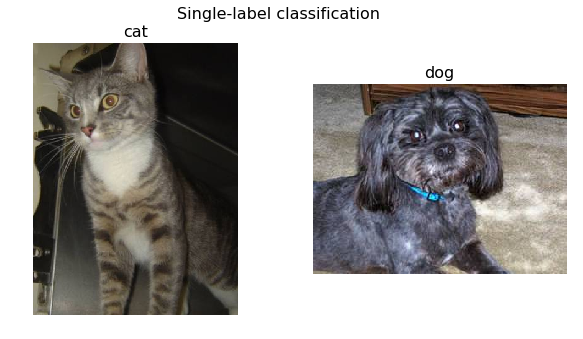

In [7]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

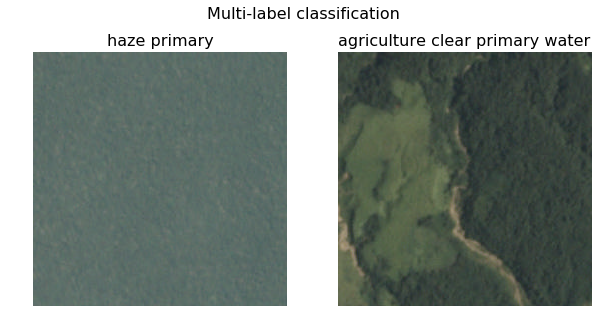

In [8]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

Multi-label是指，数据集一共有4种天气标签，而每张图都可能有多个标签。
【注意】Multi-label classification不能用`softmax`，因为`softmax`的personality是pick out just one thing，而不是多个标签的并集。

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary*(rain forest) and  *water*.

## Multi-label models for Planet dataset

In [9]:
from planet import f2

metrics=[f2]
f_model = resnet34

这里注意一下，没有用 `metrics=[accuracy]`，用的是另一个Function： **fβ**

f2是β=2时的Function。为啥用它？比赛要求的（微笑）。

In [10]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

`transforms_side_on`变成了`transforms_top_down`（vertical flip）。不是单纯的上下颠倒，而是有8种角度。

这里的`get_data`没有传入`bs`，所以batch_size是默认的64。

In [11]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [12]:
data = get_data(256)

**`val_ds` means dataset, `val_dl` means data loader.** 和PyTorch的命名统一。

ds返回单个文件，dl返回一个mini-batch。

在这`data.val_dl`返回的是transformed mini-batch。

In [13]:
# generator
x,y = next(iter(data.val_dl))

In [42]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.FloatTensor of size 64x17]

64是batch-size，17是possible classes。

对fast.ai来说，不管是single-class还是multi-class，behind the scene都是用one-hot存储的，所以没差。

check一下都是哪些classes：

In [43]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

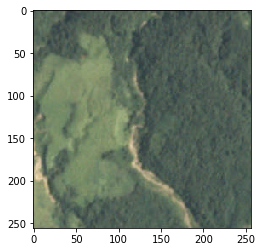

In [44]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [46]:
sz=64

planet image data starts off 256 x 256, resize data to 64x64.

这里注意一下为啥猫猫狗狗的数据集不resize，因为它们本身和ImageNet的数据集非常像，如果resize了，就相当于破坏了pre-trained model的weights。

而这个satellite的dataset本来和ImageNet就不像，所以我们相当于是从头训练。
some layers are helpful (finding edges, textures, repeating patterns)

#### Training Planet Competition Data

  * start with `sz = 64`
  * grab some data
  * built model
  * found out what learning rate to use
  * needed to fit last layer before it started out flattening out
  * then unfreeze: `learn.unfreeze()`
  * `learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)`
  * save model: `learn.save(f'{sz})`
  * train for a while
  * increase size: `sz=128` (double the size)
  * xxx
  * End with TTA:
    * `tta = learn.TTA()`
    * `f2(*tta)`
  * used `metrics=[f2]` rather than `metrics=[accuracy]`
  * **f2** particular way of weighing false positives and false negatives

Note: inputs >md.png COPYING Config.plist CopyAsMarkdown-demo.mp4 README.md _Signature.plist html2md.sh html2text.py weights = activations


In [119]:
data = get_data(sz)

In [120]:
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

  0%|          | 0/32384 [00:00<?, ?it/s]

TypeError: descriptor 'tdeadline' for '_Timeout' objects doesn't apply to '_Timeout' object

Q：上面这个`data.resize`在干啥？

`data.resize(int(sz*1.3), 'tmp')`表示go through dataset，不使用size大于`sz*1.3`的那些图片，并把符合要求的图片放在tmp目录下。


In [14]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

In [15]:
??learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[0.      0.22251 0.23639 0.8331 ]                            



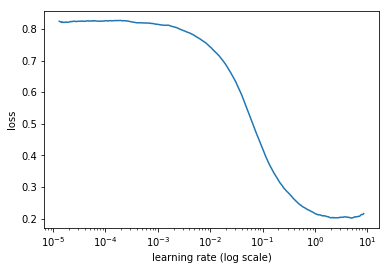

In [52]:
lrf=learn.lr_find()
learn.sched.plot()

如果你的dataset很小的话，调用learning rate finder的时候如果出现plot的图片为空的情况，可能是因为mini-batch的数量太少了，那这时就把batch-size调小一点（默认是64）。

In [53]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
                           ('output_shape', [-1, 64, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 16, 16]),
        

`lr_finder`的结果可以看到lr挺高的。然后由于satellites的image和ImageNet的不大像，所以我们要单独train一发last layer(FC层)。

In [54]:
lr = 0.2

In [55]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.14627 0.13617 0.87798]                            
[1.      0.1407  0.13123 0.88205]                            
[2.      0.13408 0.12872 0.88522]                            
[3.      0.14037 0.12834 0.88716]                            
[4.      0.134   0.12673 0.88854]                            
[5.      0.13013 0.12432 0.89077]                            
[6.      0.13157 0.12446 0.88991]                            



这里注意，因为satellite数据集和ImageNet的不像，所以这里的first/middle few layers and FC layer之间的间隔是3倍，而不是猫狗数据集采用的10倍间隔。

In [56]:
lrs = np.array([lr/9, lr/3, lr])

然后就`unfreeze()`，把前几层也train一train。

In [57]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.1194  0.1131  0.90251]                            
[1.      0.1156  0.1076  0.90796]                            
[2.      0.10683 0.1051  0.90941]                            
[3.      0.11396 0.11222 0.90083]                            
[4.      0.10553 0.1043  0.91073]                            
[5.      0.1026  0.10157 0.91284]                             
[6.      0.09741 0.1005  0.91422]                             



In [58]:
learn.save(f'{sz}')

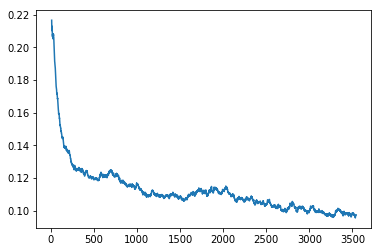

In [59]:
learn.sched.plot_loss()

[0, 500]是cycle1，[500, 1500]是cycle2，[1500, 3500]是cycle3。

**Increase, double the size of images.**

In [60]:
sz=128

In [61]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.09609 0.09831 0.91525]                             
[1.      0.09655 0.09782 0.91549]                             
[2.      0.09666 0.09696 0.91655]                             
[3.      0.09592 0.09609 0.91871]                             
[4.      0.09709 0.09602 0.91711]                             
[5.      0.09184 0.09494 0.91873]                             
[6.      0.09207 0.09494 0.91821]                             



In [62]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.09228 0.08944 0.92415]                             
[1.      0.09173 0.09064 0.92321]                             
[2.      0.08776 0.08882 0.9253 ]                             
[3.      0.0914  0.08905 0.92615]                             
[4.      0.09015 0.08765 0.92647]                             
[5.      0.08389 0.08695 0.92643]                             
[6.      0.07927 0.08693 0.92666]                             



**Double size again.**

In [125]:
sz=256

In [64]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.08934 0.09106 0.92199]                             
[1.      0.08774 0.09106 0.92191]                             
[2.      0.08708 0.09075 0.92227]                             
[3.      0.08966 0.0905  0.92306]                             
[4.      0.08718 0.09055 0.923  ]                             
[5.      0.08953 0.08968 0.92372]                             
[6.      0.08523 0.09015 0.92344]                             



In [65]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.08472 0.08514 0.92871]                             
[1.      0.08619 0.08852 0.92273]                             
[2.      0.08344 0.08417 0.92974]                             
[3.      0.08662 0.08714 0.92717]                             
[4.      0.08406 0.08396 0.92923]                             
[5.      0.07832 0.08289 0.9308 ]                             
[6.      0.07758 0.08297 0.93098]                             



Test Time Argument

Old version TTA:

In [77]:
#test_preds,y = learn.TTA()
#preds = np.mean(np.exp(log_preds),0)

New version TTA:

In [127]:
valid_tta_preds,y = learn.TTA()
valid_preds = np.mean(valid_tta_preds, axis=0)
# probs = np.exp(valid_preds)

In [93]:
valid_preds[:2]

array([[0.76137, 0.00297, 0.02642, 0.00181, 0.00108, 0.99942, 0.00007, 0.00031, 0.39254, 0.02003, 0.00046,
        0.00033, 0.9995 , 0.1634 , 0.0031 , 0.01159, 0.84485],
       [0.0687 , 0.00006, 0.00068, 0.00025, 0.00067, 0.00041, 0.0002 , 0.00004, 0.01911, 0.0004 , 0.00008,
        0.99811, 0.99985, 0.00155, 0.00029, 0.00061, 0.04431]], dtype=float32)

In [75]:
y[:2]

array([[1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.]], dtype=float32)

In [131]:
f2(valid_preds, y)

0.9314051481621938

### Submission

In [130]:
data.test_ds.n

61191

In [132]:
test_preds, _ = learn.TTA(is_test=True)
test_preds = np.mean(test_preds, axis=0)
#probs = np.exp(test_preds)

In [83]:
??planet.opt_th

```python
def opt_th(preds, targs, start=0.17, end=0.24, step=0.01):
    ths = np.arange(start,end,step)
    idx = np.argmax([fbeta_score(targs, (preds > th), 2, average='samples')
                for th in ths])
    return ths[idx]
```

For this competition and for most multi-label problems like this, you'll need to choose an optimal “threshold” so anything above it is considered and anything below it is not. Luckily the fastai library has a function called `opt_th` that actually finds the threshold for us! You can find it in the `planet.py` file.

A lot of people used 0.2 as a good fixed threshold for all labels in this comp, 0.5 would be too high. Using `opt_th` of course should be even better as the optimal threshold shouldn't be the same value for all labels.

In [96]:
opt_th=planet.opt_th(valid_preds, y)
opt_th

0.19000000000000003

In [133]:
classes = np.array(data.classes)
res = np.array([" ".join(classes[(np.where(pp > opt_th))]) for pp in test_preds])


In [104]:
res[:10]

array(['clear primary', 'clear primary', 'clear primary', 'clear primary',
       'agriculture clear cultivation primary', 'clear primary',
       'agriculture clear habitation primary road water', 'cloudy primary water',
       'agriculture clear habitation primary road', 'clear primary'], dtype='<U107')

In [134]:
res.shape

(61191,)

In [135]:
filenames = np.array([os.path.basename(fn).split('.')[0] for fn in data.test_ds.fnames])
frame=pd.DataFrame(res, index=filenames, columns=['tags'])
frame.head()

,tags
test_12407,agriculture conventional_mine partly_cloudy pr...
test_21958,clear primary road
file_10519,clear primary
test_25331,clear primary
test_30045,clear primary


In [136]:
frame.to_csv(f'{PATH}planet_restnet34_180115.csv', index_label='image_name')

In [137]:
df = pd.read_csv(f'{PATH}planet_restnet34_180115.csv')

In [138]:
df.head()

,image_name,tags
0,test_12407,agriculture conventional_mine partly_cloudy pr...
1,test_21958,clear primary road
2,file_10519,clear primary
3,test_25331,clear primary
4,test_30045,clear primary


In [139]:
df.shape

(61191, 2)

### End